## Libraies:

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import model_selection, preprocessing, metrics
from keras.models import Model
from keras.layers import Input, LSTM, Dense, TimeDistributed, Bidirectional # Keras's layers
from tqdm import tqdm
from collections import Counter

## Common settings and params:

In [24]:
# Change working directory:
os.chdir('C:/Users/User/Desktop/VegaVAD project/')
train_file_1 = 'data/train_features1.csv'
train_file_2 = 'data/train_features2.csv'
test_file_1 = 'data/test_features1.csv'
test_file_2 = 'data/test_features2.csv'

# Common params:
fs = 16000
frame_length = 0.025
frame_step = 0.01

# Params for ViVoVAD model:
n_frames = 300 # Number frames in one batch for BILSTM
epochs_ViVoVAD = 25 # Number epochs for BILSTM
batch_size_ViVoVAD = 64 # Number batchs for BILSTM

# Params for Hybrid CNN-BiLSTM:

## Load data:

In [3]:
train_1 = pd.read_csv(train_file_1, header=None)
train_2 = pd.read_csv(train_file_2, header=None)
valid_1 = pd.read_csv(test_file_1, header=None)
valid_2 = pd.read_csv(test_file_2, header=None)

train_1 = np.array(train_1)
train_2 = np.array(train_2)
valid_1 = np.array(valid_1)
valid_2 = np.array(valid_2)

print('Train size', train_1.shape, train_2.shape)
print('Valid size', valid_1.shape, valid_2.shape)

Train size (897000, 34) (27000, 1025)
Valid size (299000, 34) (9000, 1025)


# ViVoVAD:a Voice Activity Detection Tool based on Recurrent Neural Networks

## Build and training model:

We will use BLSTM layers stacked with linear layer on output. In order to reduce the delay of the dependencies, training and evaluation is perfomed with limited length sequences of 300 frames (3 seconds).

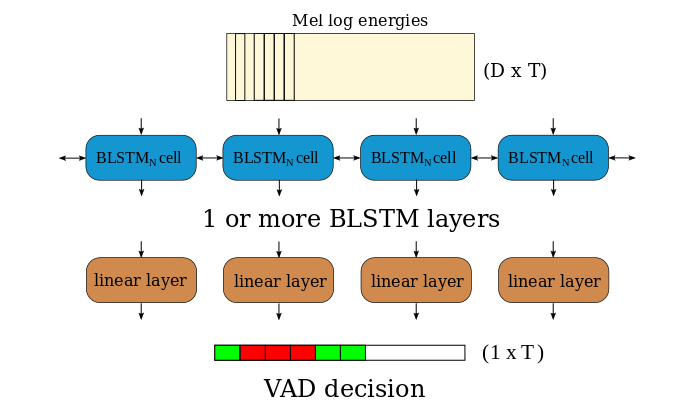

## Preparation data:

We need to split into test and train sets and to scale data to input the model.

In [4]:
# Split dataset on train and test:
X = train_1[:, 1:]
y = train_1[:, 0]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, shuffle=True, random_state=1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Scale data:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape datasets to 1 x 300 x num_features:
# So, each group need to consist of 300 frames:
X_train_reshaped = X_train[:int(X_train.shape[0] / n_frames) * n_frames]
X_train_reshaped = X_train_reshaped.reshape(int(X_train_reshaped.shape[0] / n_frames), n_frames, X_train_reshaped.shape[1])
X_test_reshaped = X_test[:int(X_test.shape[0] / n_frames) * n_frames]
X_test_reshaped = X_test_reshaped.reshape(int(X_test_reshaped.shape[0] / n_frames), n_frames, X_test_reshaped.shape[1])

(600990, 33) (296010, 33) (600990,) (296010,)


In [5]:
# Encoding label:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

y_train_reshaped = y_train[:int(y_train.shape[0] / n_frames) * n_frames]
y_train_reshaped = y_train_reshaped.reshape(int(y_train_reshaped.shape[0] / n_frames), n_frames, y_train_reshaped.shape[1])
y_test_reshaped = y_test[:int(y_test.shape[0] / n_frames) * n_frames]
y_test_reshaped = y_test_reshaped.reshape(int(y_test_reshaped.shape[0] / n_frames), n_frames, y_test_reshaped.shape[1])

## Build and fit model:

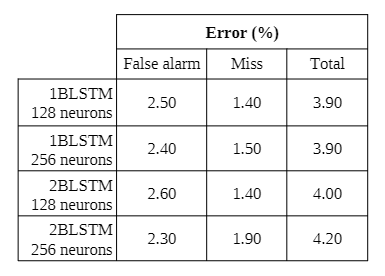
According pics we need to use the next struct for model:
1 layer with 128 neurons to reduse miss.

In [6]:
input_layer = Input(shape=(n_frames, X_train.shape[1]))
BLSTM_1_layer = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
output_layer = TimeDistributed(Dense(3, activation='softmax'))(BLSTM_1_layer)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
model.fit(X_train_reshaped, y_train_reshaped, validation_data=(X_test_reshaped, y_test_reshaped), epochs=epochs_ViVoVAD, batch_size=batch_size_ViVoVAD)

Epoch 1/25
32/32 [==============================] - ETA: 15:24 - loss: 1.0934 - accuracy: 0.367 - ETA: 24s - loss: 1.0880 - accuracy: 0.3799  - ETA: 25s - loss: 1.0833 - accuracy: 0.388 - ETA: 26s - loss: 1.0788 - accuracy: 0.396 - ETA: 25s - loss: 1.0747 - accuracy: 0.402 - ETA: 24s - loss: 1.0710 - accuracy: 0.408 - ETA: 22s - loss: 1.0675 - accuracy: 0.413 - ETA: 21s - loss: 1.0642 - accuracy: 0.418 - ETA: 20s - loss: 1.0611 - accuracy: 0.422 - ETA: 19s - loss: 1.0583 - accuracy: 0.426 - ETA: 18s - loss: 1.0556 - accuracy: 0.430 - ETA: 17s - loss: 1.0530 - accuracy: 0.433 - ETA: 16s - loss: 1.0505 - accuracy: 0.436 - ETA: 15s - loss: 1.0481 - accuracy: 0.439 - ETA: 15s - loss: 1.0458 - accuracy: 0.442 - ETA: 14s - loss: 1.0436 - accuracy: 0.444 - ETA: 13s - loss: 1.0414 - accuracy: 0.447 - ETA: 12s - loss: 1.0392 - accuracy: 0.449 - ETA: 11s - loss: 1.0371 - accuracy: 0.451 - ETA: 10s - loss: 1.0350 - accuracy: 0.453 - ETA: 10s - loss: 1.0330 - accuracy: 0.456 - ETA: 9s - loss: 1.03

32/32 [==============================] - ETA: 32s - loss: 0.6996 - accuracy: 0.703 - ETA: 33s - loss: 0.6974 - accuracy: 0.704 - ETA: 30s - loss: 0.6968 - accuracy: 0.704 - ETA: 30s - loss: 0.6970 - accuracy: 0.704 - ETA: 28s - loss: 0.6969 - accuracy: 0.704 - ETA: 27s - loss: 0.6967 - accuracy: 0.704 - ETA: 26s - loss: 0.6966 - accuracy: 0.704 - ETA: 25s - loss: 0.6964 - accuracy: 0.704 - ETA: 24s - loss: 0.6962 - accuracy: 0.704 - ETA: 23s - loss: 0.6961 - accuracy: 0.704 - ETA: 22s - loss: 0.6959 - accuracy: 0.704 - ETA: 21s - loss: 0.6958 - accuracy: 0.704 - ETA: 20s - loss: 0.6957 - accuracy: 0.704 - ETA: 19s - loss: 0.6956 - accuracy: 0.704 - ETA: 18s - loss: 0.6956 - accuracy: 0.704 - ETA: 17s - loss: 0.6955 - accuracy: 0.704 - ETA: 16s - loss: 0.6954 - accuracy: 0.705 - ETA: 15s - loss: 0.6953 - accuracy: 0.705 - ETA: 14s - loss: 0.6952 - accuracy: 0.705 - ETA: 13s - loss: 0.6950 - accuracy: 0.705 - ETA: 11s - loss: 0.6949 - accuracy: 0.705 - ETA: 10s - loss: 0.6948 - accuracy:

32/32 [==============================] - ETA: 29s - loss: 0.6214 - accuracy: 0.745 - ETA: 30s - loss: 0.6221 - accuracy: 0.745 - ETA: 31s - loss: 0.6230 - accuracy: 0.744 - ETA: 31s - loss: 0.6232 - accuracy: 0.743 - ETA: 30s - loss: 0.6232 - accuracy: 0.743 - ETA: 28s - loss: 0.6231 - accuracy: 0.743 - ETA: 27s - loss: 0.6231 - accuracy: 0.743 - ETA: 26s - loss: 0.6233 - accuracy: 0.743 - ETA: 25s - loss: 0.6233 - accuracy: 0.743 - ETA: 24s - loss: 0.6234 - accuracy: 0.743 - ETA: 23s - loss: 0.6234 - accuracy: 0.742 - ETA: 22s - loss: 0.6234 - accuracy: 0.742 - ETA: 20s - loss: 0.6234 - accuracy: 0.742 - ETA: 19s - loss: 0.6233 - accuracy: 0.742 - ETA: 18s - loss: 0.6233 - accuracy: 0.742 - ETA: 17s - loss: 0.6232 - accuracy: 0.742 - ETA: 16s - loss: 0.6231 - accuracy: 0.742 - ETA: 15s - loss: 0.6231 - accuracy: 0.742 - ETA: 14s - loss: 0.6230 - accuracy: 0.742 - ETA: 13s - loss: 0.6230 - accuracy: 0.742 - ETA: 12s - loss: 0.6229 - accuracy: 0.742 - ETA: 11s - loss: 0.6229 - accuracy:

32/32 [==============================] - ETA: 28s - loss: 0.5922 - accuracy: 0.759 - ETA: 23s - loss: 0.5924 - accuracy: 0.757 - ETA: 27s - loss: 0.5925 - accuracy: 0.757 - ETA: 28s - loss: 0.5925 - accuracy: 0.757 - ETA: 27s - loss: 0.5923 - accuracy: 0.756 - ETA: 27s - loss: 0.5922 - accuracy: 0.756 - ETA: 26s - loss: 0.5920 - accuracy: 0.756 - ETA: 25s - loss: 0.5921 - accuracy: 0.756 - ETA: 24s - loss: 0.5921 - accuracy: 0.756 - ETA: 23s - loss: 0.5923 - accuracy: 0.756 - ETA: 22s - loss: 0.5924 - accuracy: 0.756 - ETA: 21s - loss: 0.5924 - accuracy: 0.756 - ETA: 20s - loss: 0.5925 - accuracy: 0.756 - ETA: 19s - loss: 0.5926 - accuracy: 0.756 - ETA: 18s - loss: 0.5926 - accuracy: 0.756 - ETA: 17s - loss: 0.5927 - accuracy: 0.756 - ETA: 16s - loss: 0.5927 - accuracy: 0.756 - ETA: 15s - loss: 0.5927 - accuracy: 0.756 - ETA: 14s - loss: 0.5927 - accuracy: 0.756 - ETA: 13s - loss: 0.5927 - accuracy: 0.756 - ETA: 12s - loss: 0.5927 - accuracy: 0.756 - ETA: 10s - loss: 0.5927 - accuracy:

32/32 [==============================] - ETA: 30s - loss: 0.5811 - accuracy: 0.760 - ETA: 28s - loss: 0.5799 - accuracy: 0.762 - ETA: 29s - loss: 0.5788 - accuracy: 0.763 - ETA: 30s - loss: 0.5783 - accuracy: 0.763 - ETA: 29s - loss: 0.5781 - accuracy: 0.764 - ETA: 28s - loss: 0.5781 - accuracy: 0.764 - ETA: 27s - loss: 0.5781 - accuracy: 0.764 - ETA: 26s - loss: 0.5780 - accuracy: 0.764 - ETA: 25s - loss: 0.5778 - accuracy: 0.764 - ETA: 24s - loss: 0.5776 - accuracy: 0.764 - ETA: 23s - loss: 0.5775 - accuracy: 0.764 - ETA: 22s - loss: 0.5774 - accuracy: 0.764 - ETA: 21s - loss: 0.5774 - accuracy: 0.764 - ETA: 20s - loss: 0.5772 - accuracy: 0.764 - ETA: 19s - loss: 0.5772 - accuracy: 0.764 - ETA: 17s - loss: 0.5771 - accuracy: 0.764 - ETA: 16s - loss: 0.5770 - accuracy: 0.764 - ETA: 15s - loss: 0.5770 - accuracy: 0.764 - ETA: 14s - loss: 0.5769 - accuracy: 0.764 - ETA: 13s - loss: 0.5769 - accuracy: 0.764 - ETA: 12s - loss: 0.5768 - accuracy: 0.764 - ETA: 11s - loss: 0.5768 - accuracy:

## Do the validation:

In [28]:
X_valid = valid_1[:, 1:]
order_record = valid_1[:, 0]
last_number = order_record[-1]
list_number = np.arange(0, last_number + 1, 1)
list_predicted_labels = list()

# Scaling:
X_valid = scaler.transform(X_valid)

for i in list_number:
    # Choose frames:
    indexes = [j for j in range(len(order_record)) if order_record[j] == i]
    
    # Reshape datasets to 1 x 300 x num_features:
    X_valid_tmp = X_valid[indexes[0]:indexes[-1] + 1]
    if X_valid_tmp.shape[0] < n_frames:
        added_frames = np.zeros((n_frames - X_valid_tmp.shape[0], X_valid_tmp.shape[1]))
        X_valid_tmp = np.vstack((X_valid_tmp, added_frames))
    X_valid_reshaped = X_valid_tmp[:int(X_valid_tmp.shape[0] / n_frames) * n_frames]
    X_valid_reshaped = X_valid_reshaped.reshape(int(X_valid_reshaped.shape[0] / n_frames), n_frames, X_valid_reshaped.shape[1])
    prediction = model.predict(X_valid_reshaped)
    
    predicted_label = np.zeros(prediction.shape[0] * prediction.shape[1])
    shift = prediction.shape[1]
    for j in range(prediction.shape[0]):
        for jj in range(prediction.shape[1]):
            predicted_label[jj + j * shift] = np.argmax(prediction[j][jj])
            
    list_predicted_labels.append(Counter(predicted_label).most_common()[0][0])

In [29]:
list_predicted_labels

[0.0,
 2.0,
 2.0,
 0.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 1.0,
 0.0,
 0.0,
 2.0,
 0.0,
 2.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 2.0,
 1.0,
 1.0,
 2.0,
 0.0,
 0.0,
 2.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 2.0,
 0.0,
 1.0,
 2.0,
 1.0,
 0.0,
 2.0,
 0.0,
 1.0,
 2.0,
 2.0,
 0.0,
 2.0,
 0.0,
 1.0,
 1.0,
 0.0,
 2.0,
 2.0,
 2.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.0,
 0.0,
 2.0,
 2.0,
 2.0,
 2.0,
 0.0,
 0.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 1.0,
 1.0,
 1.0,
 0.0,
 2.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 2.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 2.0,
 2.0,
 0.0,
 1.0,
 0.0,
 2.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 0.0,
 1.0,
 1.0,
 2.0,
 1.0,
 2.0,
 1.0,
 2.0,
 0.0,
 2.0,
 0.0,
 2.0,
 1.0,
 2.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 2.0,
 0.0,
 2.0,
 2.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 2.0,
 1.0,
 2.0,
 1.0,
 2.0,
 2.0,
 2.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 2.0,
 2.0,
 2.0,
 0.0,
 2.0,
 2.0,
 0.0,
 0.0